[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/samdavanloo/ISE-ML/blob/main/3_logistic_regression.ipynb)

# Classification: Logistic regression
Logistic regression is a classification model that is very easy to implement but performs very well on linearly separable classes. It is one of the most widely used algorithms for classification in industry. Logistic regression is a linear model for binary classification that can be extended to multiclass classification.

The "odds ratio" of an event (class label $y=1$) is defined as $p/(1-p)$ where $p$ is the probability of the event.

The "logit function" is then the natural logarithm of the odds ration:
$$
logit(p) = \log\frac{p}{1-p}
$$
The logit function takes as input values in the range of 0 to 1 and transforms them to values over the entire real-number range, which can then be modeled by a linear function:
$$
logit(p(y=1|\mathbf{x})) = w_0+w_1x_1+\cdots+w_px_p=w_0+\mathbf{w}^T\mathbf{x}.
$$
Note taht we are actually interested in predicting the "probability" that a certain sample belongs to a particular class, which is the inverse form of the logit function. It is also called logistic "sigmoid function" and defined as
$$
\phi(z) = \frac{1}{1+e^{-z}},
$$
where 
$$
z=w_0+\mathbf{w}^T\mathbf{x}.
$$ 

Given some "threshold", the predicted probability can simply be converted into a binary outcome via the function:
$$
\hat{y} =
\begin{cases}
1 \quad \text{if}\ \phi(z)\geq \text{threshold} \\
0 \quad \text{otherwise}
\end{cases}
$$


### Learning (estimating) the parameters
Parameters of the logistic regression model are generally estimated by maximizing the "likelihood" function. Assuming that the individual samples in our dataset are independent of one another, the likelihood function can be written as
$$
L(\mathbf{w},w_0) = \Pi_{i=1}^n p(y_i|\mathbf{x}_i) = \Pi_{i=1}^n \phi(z(\mathbf{x}_i;\mathbf{w},w_0))^{y_i} (1-\phi(z(\mathbf{x}_i;\mathbf{w},w_0)))^{1-y_i},
$$
or log-likelihood which has the form
$$
l(\mathbf{w},w_0) = \log L(\mathbf{w},w_0) = \sum_{i=1}^n \Big(y_i\log(\phi(z(\mathbf{x}_i;\mathbf{w},w_0)))+(1-y_i)\log(1-\phi(z(\mathbf{x}_i;\mathbf{w},w_0)))\Big).
$$
Instead of maximizing log-likelihood, it is a common practice to minimize negative log-likelihood as
$$
\min_{\mathbf{w}\in \mathbb{R}^p, w_0\in \mathbb{R}}\ \cal{L}(\mathbf{w},w_0) \triangleq \sum_{i=1}^n \Big(-y_i\log(\phi(z(\mathbf{x}_i;\mathbf{w},w_0)))-(1-y_i)\log(1-\phi(z(\mathbf{x}_i;\mathbf{w},w_0)))\Big).
$$

Note that with $n=1$ the objective function is equivalent to
$$
\cal{L}(\mathbf{w},w_0) = 
\begin{cases}
-\log(\phi(z(\mathbf{x};\mathbf{w},w_0))) \ \ \quad \quad \text{if} \ \  y=1 \\
-\log(1-\phi(z(\mathbf{x};\mathbf{w},w_0))) \quad \text{if} \ \ y=0.
\end{cases}
$$
Let's quickly check the optimization objective for $n=1$. 

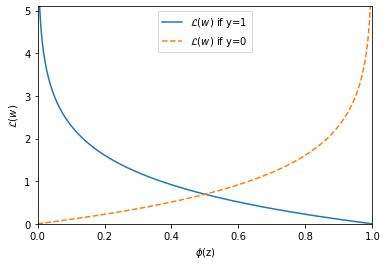

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
def cost_1(z):
    return - np.log(sigmoid(z))
def cost_0(z):
    return - np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='$\mathcal{L}(w)$ if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='$\mathcal{L}(w)$ if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('$\mathcal{L}(w)$')
plt.legend(loc='best')
plt.show()

Note that $\phi(z)$ is the "probability of class 1". We can see that the cost approaches 0 if we correctly predict the class.

Using the chain rule, one can show that
\begin{align*}
\nabla_{\mathbf{w}}\mathcal{L}(\mathbf{w},w_0) &= \sum_{i=1}^n(\phi(z(\mathbf{x}_i;\mathbf{w},w_0))-y_i)\mathbf{x}_i. \\ 
\nabla_{w_0}\mathcal{L}(\mathbf{w},w_0) &= \sum_{i=1}^n(\phi(z(\mathbf{x}_i;\mathbf{w},w_0))-y_i),
\end{align*}
which are used in the Gradient Descent optimization algorithm below.

In [2]:
class LogisticRegressionGD(object):

    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
    Learning rate (between 0.0 and 1.0)
    n_iter : int   Passes over the training dataset.
    random_state : int    Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array    Weights after fitting.
    cost_ : list    Sum-of-squares cost function value in each epoch.

    """

    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number of
        samples and
        n_features is the number of features.
        y : array-like, shape = [n_samples]
        Target values.
        Returns
        -------
        self : object
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
        size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (-y.dot(np.log(output)) -
            ((1 - y).dot(np.log(1 - output))))
            self.cost_.append(cost)
        
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
            """Compute logistic sigmoid activation"""
            return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
            """Return class label after unit step"""
            return np.where(self.net_input(X) >= 0.0, 1, 0)
            # equivalent to:
            # return np.where(self.activation(self.net_input(X))
            # >= 0.5, 1, 0)



We will work on the famous Iris dataset. We will assign the petal length and petal width of the 150 flower samples to the
feature matrix X and the corresponding class labels of the flower species to the vector y.

In [3]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


To evaluate how well a trained model performs on unseen data, we will further split the dataset into separate training and test datasets.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

We have to keep in mind that it only works for binary classification tasks. So, let us consider only Iris-setosa and
Iris-versicolor flowers (classes 0 and 1):

In [5]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

We need a plotting function that is defined below:

In [6]:

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None,resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
        alpha=0.8, c=colors[idx],
        marker=markers[idx], label=cl,
        edgecolor='black')
        
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],c="g", edgecolor='black', 
        alpha=1.0,linewidth=1, marker='o',s=100, label='test set')


Finally, we will instanciate the class defined above and fit logistic regression using the fit methos:

/var/folders/6c/mzld6tfn7g1cw7rzfxzv544h0000gp/T/ipykernel_11766/271874885.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


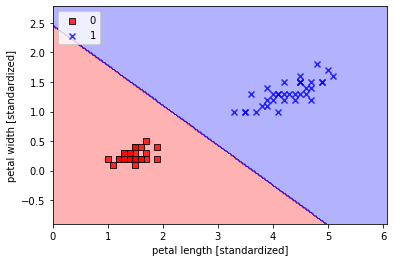

In [7]:
lrgd = LogisticRegressionGD(eta=0.05,n_iter=1000,random_state=1)
lrgd.fit(X_train_01_subset,y_train_01_subset)

plot_decision_regions(X=X_train_01_subset,y=y_train_01_subset,classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()

## Training a logistic regression model with scikit-learn
In the following code, we will use the sklearn package to fit logistic regression. First, we will standardize the features using the StandardScaler class from scikit-learn's preprocessing module.

/var/folders/6c/mzld6tfn7g1cw7rzfxzv544h0000gp/T/ipykernel_11766/271874885.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


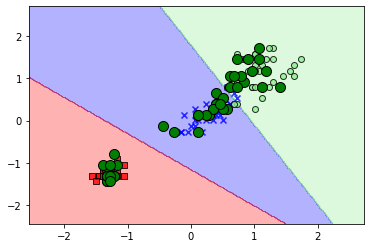

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))


from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std,y_combined,classifier=lr,test_idx=range(105, 150))
#plt.xlabel('petal length [standardized]')
#plt.ylabel('petal width [standardized]')
#plt.legend(loc='upper left')
#plt.show()


The probability that training examples belong to a certain class can be computed using the "predict_proba" method. Each row contains the class membership of one flower for three classes.

In [22]:
lr.predict_proba(X_test_std[:3, :])

array([[2.26332469e-20, 6.62130359e-05, 9.99933787e-01],
       [9.99870019e-01, 1.29981440e-04, 6.34998610e-21],
       [9.99992811e-01, 7.18853591e-06, 1.23962827e-23]])

## Avoid overfitting via regularization
Overfitting is a common problem in machine learning, where a model performs well
on training data but does not generalize well to unseen data (test data). If a model
suffers from overfitting, we also say that the model has a high variance, which can
be caused by having too many parameters that lead to a model that is too complex
given the underlying data. Similarly, our model can also suffer from underfitting
(high bias), which means that our model is not complex enough to capture the
pattern in the training data well and therefore also suffers from low performance on
unseen data.

We will regularize the logistic loss function with $\ell_2$-norm penalty as
$$
\cal{L}_{\lambda}(\mathbf{w},w_0) \triangleq \sum_{i=1}^n \Big(-y_i\log(\phi(z_i;\mathbf{w},w_0))-(1-y_i)\log(1-\phi(z_i;\mathbf{w},w_0))\Big) + \frac{\lambda}{2}||\mathbf{w}||_2^2,
$$
where $\lambda$ is the regularization parameter. Increasing $\lambda$ increases the regularization strength which pushes elements of $\mathbf{w}$ to zero. This change to the objective function will slighly change the update in the GD algorithm which will not discuss.

The parameter "C" that is implemented for the "LogisticRegression" class in scikit-learn is the inverse of the $\lambda$ parameter above. Consequently, decreasing the value of C increases the regularization strength and vice versa.

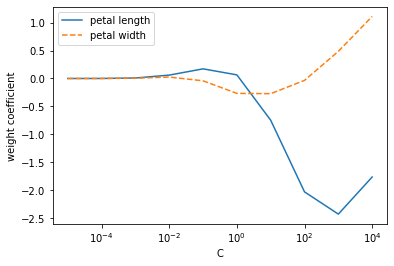

In [27]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0],label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()


As we can see in the plot, the weight coefficients shrink as parameter C decreases, i.e., regularization parameter $\lambda$ increases.